# <center> Computing fully marginalized likelihoods for n-planet models </center>
<img src="fml.jpg">

In this notebook, we will compute the fully marginalized likelihood (i.e. FML, Bayesian evidence) for two specified models $\mathcal{M}$ applied to radial velocity data $\vec{d}$. The notebook will proceed in three phases:

1. [generating a synthetic dataset](#section1) of a known system (two planets)
2. [performing an MCMC](#section2) to get posterior samples of two competing models ([one planet](#section2.1) vs. [two planets](#section2.2))
3. [computing FML](#section3) for each model to yield a Bayes factor that [hopefully](#section3.4) favors the input (i.e. two planets)

We require a few modules for this to work. Some come with the standard Anaconda installation. You will have to $\tt{pip\,install}$ a few of these if you haven't already. I wrote several other functions specific to this project that can be categorized as "creating" things (e.g. formatting data in a certain way) and "computing" things (e.g. parameter transformations). These functions are located in $\tt{create.py}$ and $\tt{compute.py}$ respectively.

---

---

Feel free to experiment with the parameters here, especially the input system, observational model, and importance sampling parameters. If you decide to use the importance sampling algorithm described here for your own project, please cite [Nelson et al. 2016](http://adsabs.harvard.edu/abs/2016MNRAS.455.2484N).

---

In [1]:
%matplotlib inline

# If you installed Python through Anaconda, you probably have these.
import pylab as plt
import numpy as np
from collections import OrderedDict
from itertools import chain

# You'll need to install these modules separately through e.g. pip.
import emcee # for doing MCMC
import corner # for multi-dimensional plotting
import rebound # for doing the model evaluation

# These .py files should reside in the same directory as the notebook.
import compute
import create
import observations

<a id='section1'></a>
## <center> 1. Simulate radial velocity data for a known system.</center>

We will generate a synthetic dataset from a two-planet model. These planets will be on approximately Keplerian (i.e. non-interacting) orbits around a 1 $M_\odot$ star on the observing timescale.

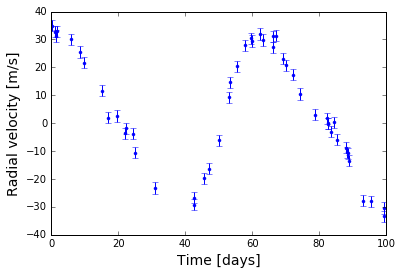

In [2]:
# central star mass
mStar = 1.0

# set orbital parameters for n-planets here
params_true = {"period": [30., 61.],\
               "half-amp": [7., 30.],\
               "eccentricity": [0.2, 0.1],\
               "argperi": [np.pi/2., np.pi/3.],\
               "meanomaly": [np.pi/4., 0.]}

# params_true_by_planet: list of lists that is essentially params_true transposed
# params_true_chained: all parameters as 1-d list
params_true_by_planet, params_true_chained = create.input_format(params_true)
nPlanets_true = len(params_true_by_planet)

# generate synthetic RV measurements
obs = observations.FakeObservation(compute.sma_and_mass(params_true_chained, mStar),\
                                   nPoints=50, error=2.0, tmax=100., mStar=mStar)

# plot the RV data
plt.errorbar(obs.t, obs.rv, yerr=obs.err, fmt='.')
plt.xlabel('Time [days]', fontsize=14)
plt.ylabel('Radial velocity [m/s]', fontsize=14)
plt.show()

---
<a id='section2'></a>
## <center> 2. Do the MCMC </center>

The FML algorithm in this notebook uses information from posterior samples, so we'll need to perform an MCMC on the dataset above for two competing models.

First, we'll define our likelihood, prior, and posterior. We adopt uniform priors on $e$, $\omega$, and $M$ from $\{0,1\}$, $\{0,2\pi\}$, and $\{0,2\pi\}$ respectively. We adopt modified Jeffreys priors for $p$ and $K$.

In [3]:
def lnlike(theta, obs):
    '''
    The log-likelihood function. Observational model assume RVs have independent Gaussian error bars.
        
        Parameters
        ----------
        theta : 1-d list of Keplerian orbital parameters (p, K, e, w, M)
                for every modeled planet
        obs   : observations object with radial velocity measurement (.rv)
                and uncertainty (.err) attributes
    '''
    model = compute.rv(theta, obs)
    inv_sigma2 = 1.0/(obs.err * obs.err)
    return -0.5*( np.sum( (obs.rv - model)*(obs.rv - model)*inv_sigma2 - np.log(inv_sigma2) ) )

def lnprior(theta):
    '''
    The log-prior function.
        
         Parameters
         ----------
         theta : 1-d list of Keplerian orbital parameters (p, K, e, w, M)
                 for every modeled planet
    '''
    planets = [theta[x:x+5] for x in range(0, len(theta), 5)]
    nPlanets = len(planets)
    thetaT = np.transpose(planets)
    p, K, e, w, M = thetaT[0], thetaT[1], thetaT[2], thetaT[3], thetaT[4]
    
    P0, K0 = 1., 1.
    lnp = 0.
    
    for i in range(nPlanets):
        if p[i] < 99999.and K[i] < 99999.and 0. <= e[i] < 1. \
        and 0. <= abs(w[i]) <= 2*np.pi and 0. <= abs(M[i]) <= 2*np.pi:
            lnp += -np.log(1.+p[i]/P0) - np.log(1+K[i]/K0) - 2.*np.log(2.*np.pi)
        else:
            return -np.inf
    return lnp
    
def lnpost(theta, obs):
    '''
    The log-posterior function. Sum of log-likelihood and log-prior.
        
        Parameters
        ----------
        theta : 1-d list of Keplerian orbital parameters (p, K, e, w, M)
                for every modeled planet
        obs   : observations object with radial velocity measurement (.rv)
                and uncertainty (.err) attributes
    '''
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, obs)

The MCMC needs a good starting condition in order to "burn-in" rapidly. In this notebook, we are only dealing with a handful of parameters (5-10) and fairly high signal-to-noise planets. So getting a maximum likelihood estimate (MLE) via e.g. scipy.optimize should work well enough.

Initial conditions for the MCMC will be generated by creating a small dispersion around the MLE.

In [4]:
import scipy.optimize as op

def bounds(theta):
    '''
    Bounds function. Ensures gravitationally bound orbits (0 < e < 1) and some non-negative quantities.
        
        Parameters
        ----------
        theta : 1-d list of Keplerian orbital parameters (p, K, e, w, M)
                for every modeled planet
    '''
    bnds = ()
    for i in range(int(len(theta)/5)):
        bnds = bnds + ((0., None), (0., None), (0.,1.), (-2.*np.pi, 2.*np.pi), (-2.*np.pi, 2.*np.pi))
    return bnds

def create_init(theta):
    '''
    Create initial conditions for MCMC based on input theta
        
        Parameters
        ----------
        theta : 1-d list of Keplerian orbital parameters (p, K, e, w, M)
                for every modeled planet
    '''
    nPlanets = int(len(theta)/5)
    planets = [theta[x:x+5] for x in range(0, nPlanets*5, 5)]
    init = []
    for i, planet in enumerate(planets):
        init.append(planet[0] + np.random.normal(0.,0.01))
        init.append(planet[1] + np.random.normal(0.,0.05))
        init.append(planet[2] + abs(np.random.normal(0.,0.01)))
        init.append(planet[3] + np.random.normal(0.,0.5))
        init.append(planet[4] + np.random.normal(0.,0.5))
    return init

nll = lambda *args: -lnlike(*args)

Now let's consider two competing models. One will be the true generative model (two-planets). The other will be one-planet model.

---
<a id='section2.1'></a>
### <center>2.1. One-planet model </center>

We'll use the properties of the higher signal-to-noise planet as a plausible one-planet model and get an MLE for this model.

In [5]:
system_1pl = params_true_by_planet[1]
MLE_1pl = list( op.minimize( nll, system_1pl, args=obs, bounds=bounds(system_1pl) )['x'] )

print("MLE for one-planet model           [p, K, e, w, M]:")
print(MLE_1pl)
print("")
print("Actual properties from input model [p, K, e, w, M]:")
print(system_1pl)

MLE for one-planet model           [p, K, e, w, M]:
[61.71107368376282, 31.575039301238174, 0.21968289243238895, -0.052487371737662353, 1.138789981523439]

Actual properties from input model [p, K, e, w, M]:
[61.0, 30.0, 0.1, 1.0471975511965976, 0.0]


For the one-planet model, the orbital period, RV half-amplitude, and phase angles should be roughly consistent with the outer planet in the two-planet model, but the eccentricity here should be overestimated.

---

Now, let's do the MCMC to get constraints on each of these parameters. The runtime heavily depends on the system itself, the number/extent of observations, and the parameters set for the MCMC. The one-planet MCMC should only take a couple minutes for this example.

In [6]:
nDim_1pl = len(MLE_1pl)
nWalkers_1pl = 2*nDim_1pl
init_1pl = [ create_init(MLE_1pl) for i in range(nWalkers_1pl) ]

sampler_1pl = emcee.EnsembleSampler(nWalkers_1pl, nDim_1pl, lnpost, args=[obs])
sampler_1pl.run_mcmc(init_1pl, 5500, thin=10);

In [7]:
samples_1pl = sampler_1pl.chain[:, 50:, :].reshape((-1, nDim_1pl));
print("Number of posterior samples:", len(samples_1pl))

Number of posterior samples: 5000


//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


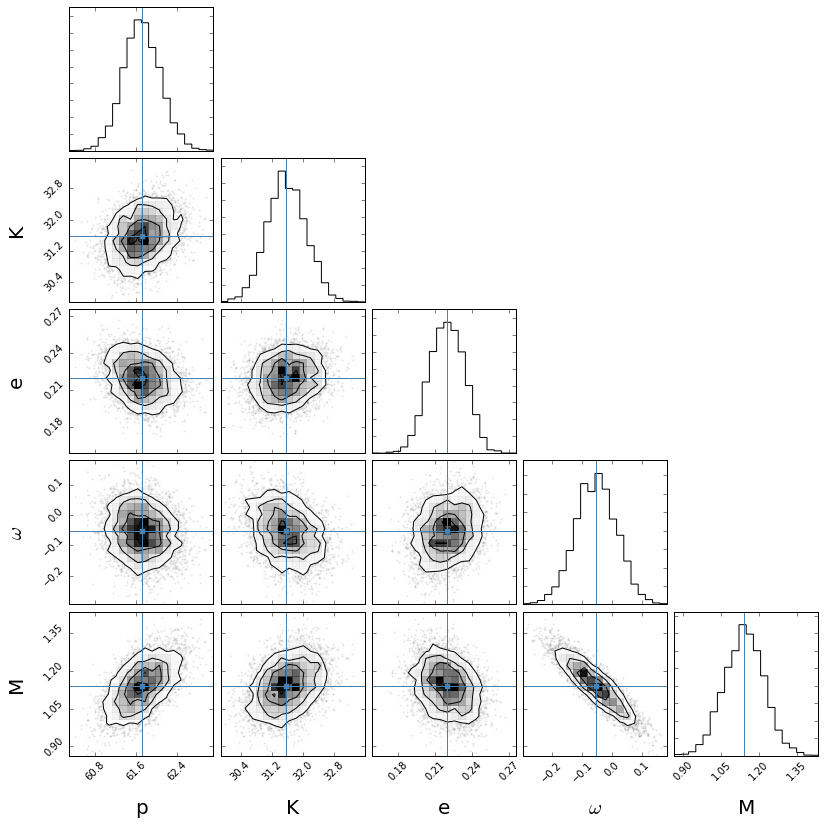

In [8]:
fig = corner.corner(samples_1pl, labels=["p","K","e","$\omega$","M"],\
                   truths=MLE_1pl, label_kwargs={"fontsize":20})
fig.show()

---
<a id='section2.2'></a>
### <center>2.2. Two-planet model </center>

Next, we will follow the same procedure as the one-planet model but with two-planet model. We will first compute a MLE which will hopefully look very similar to our input conditions.

In [9]:
system_2pl = params_true_chained
MLE_2pl = list(op.minimize( nll, system_2pl, args=obs, bounds=bounds(system_2pl))['x'])

print("MLE for two-planet model [p, K, e, w, M, ...]:")
print(MLE_2pl)
print("")
print("Actual input model       [p, K, e, w, M, ...]:")
print(system_2pl)

MLE for two-planet model [p, K, e, w, M, ...]:
[30.382411633836995, 7.6380892700844303, 0.18889695633318773, 1.9520850145516955, 0.87081095289839627, 61.203057254321244, 30.883013452552419, 0.16453384410150826, 1.2163835312776432, -0.14799759918181116]

Actual input model       [p, K, e, w, M, ...]:
[30.0, 7.0, 0.2, 1.5707963267948966, 0.7853981633974483, 61.0, 30.0, 0.1, 1.0471975511965976, 0.0]


Again, we perform MCMC but on a two-planet model. This will take considerably longer with an extra body and more Markov chains ($\tt{emcee}$ asserts that the number of walkers >= 2 * number of dimensions). I clocked this run to take roughly 20 minutes.

In [10]:
nDim_2pl = len(MLE_2pl)
nWalkers_2pl = int(1.5*nDim_2pl)*2
init_2pl = [ create_init(MLE_2pl) for i in range(nWalkers_2pl) ]

sampler_2pl = emcee.EnsembleSampler(nWalkers_2pl, nDim_2pl, lnpost, args=[obs])
sampler_2pl.run_mcmc(init_2pl, 11000, thin=40);

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in log


In [11]:
samples_2pl = sampler_2pl.chain[:, 25:, :].reshape((-1, nDim_2pl));
print("Number of posterior samples:", len(samples_2pl))

Number of posterior samples: 7500


//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


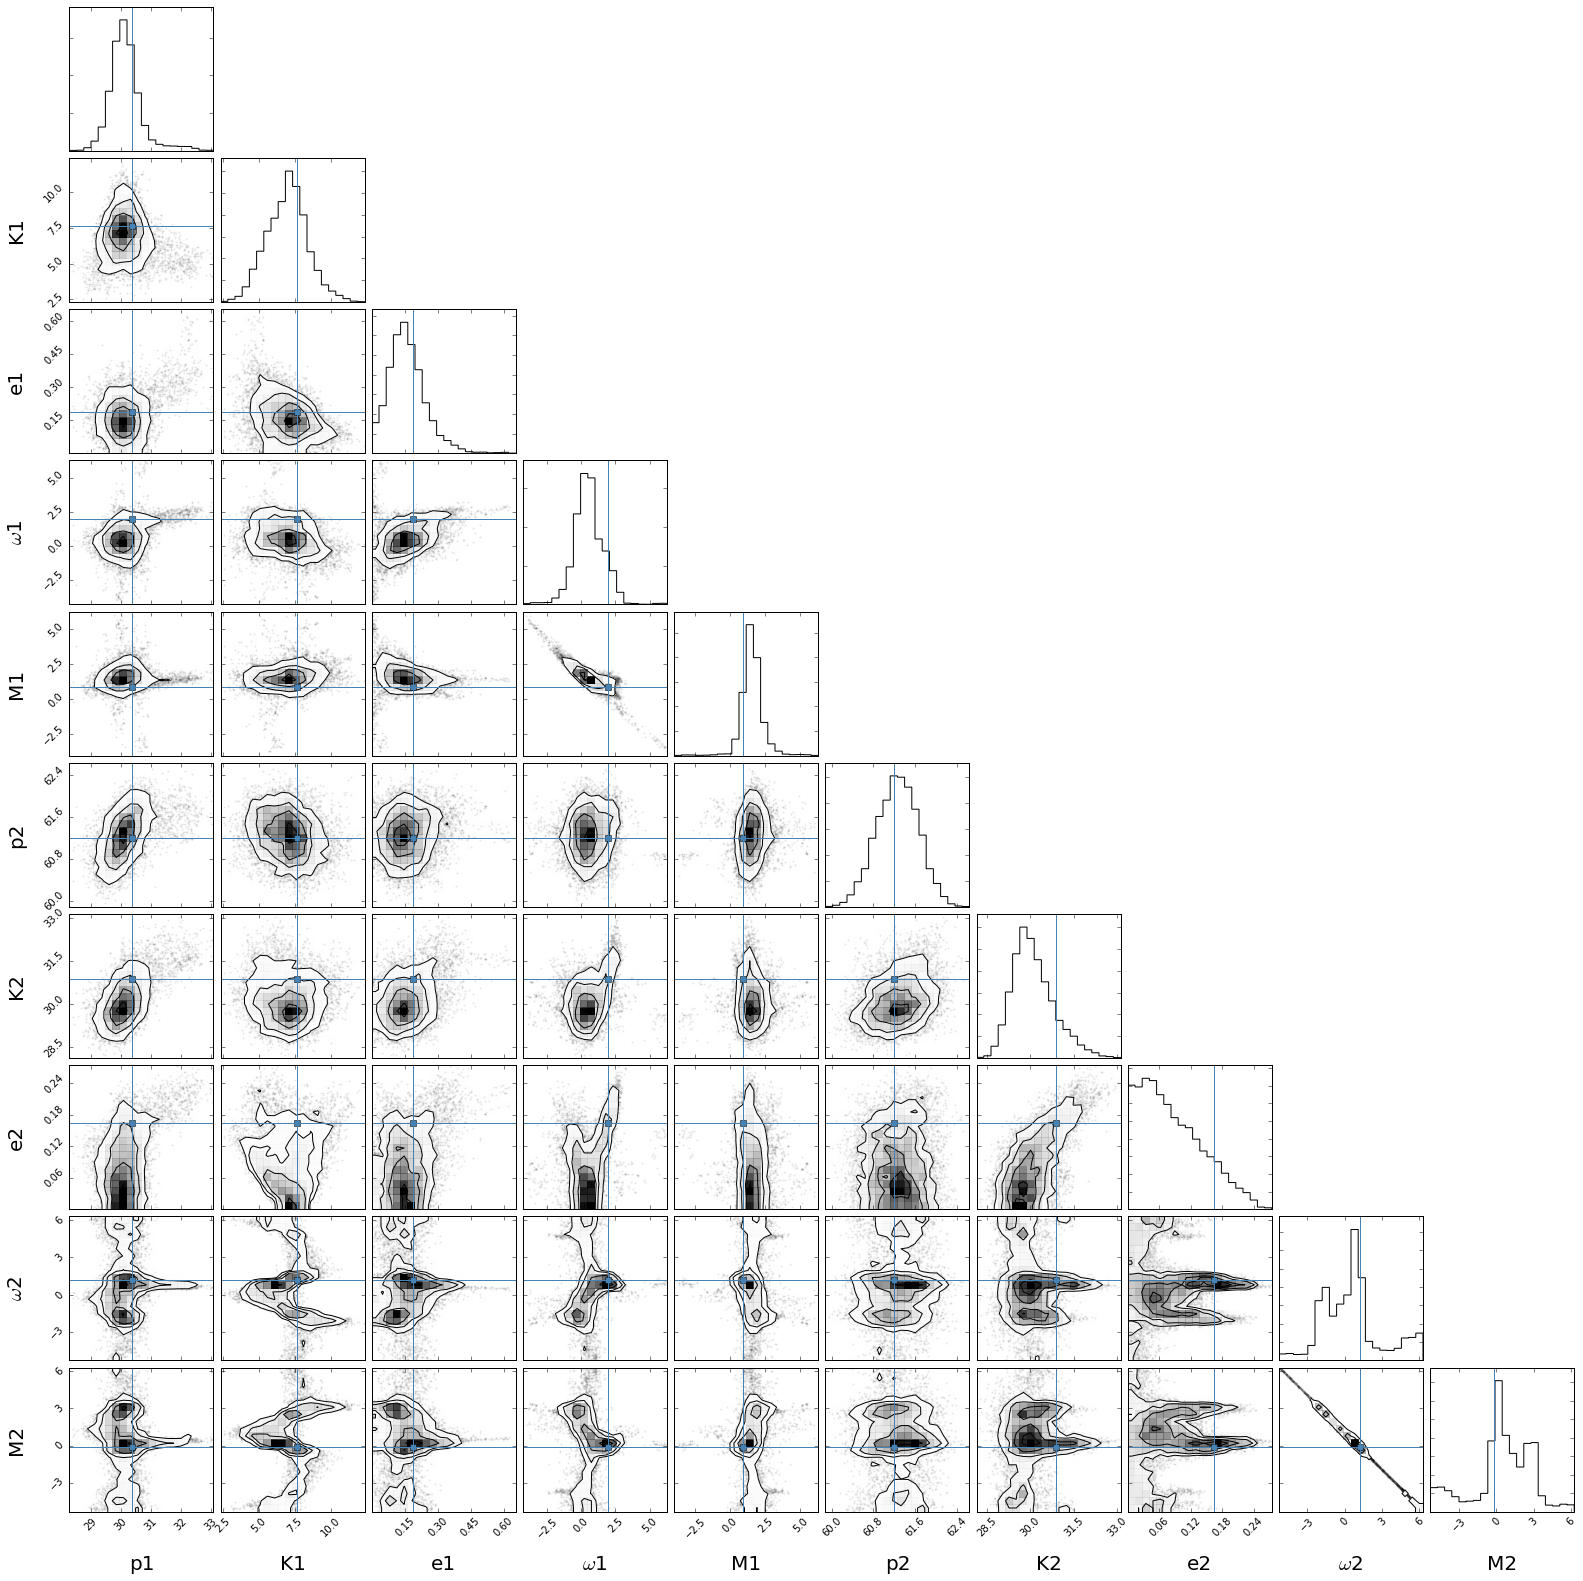

In [12]:
fig = corner.corner(samples_2pl, labels=["p1","K1","e1","$\omega$1","M1","p2","K2","e2","$\omega$2","M2"],\
                   truths=MLE_2pl, label_kwargs={"fontsize":20})
fig.show()

---
<a id='section3'></a>
## <center>3. Do the FML/Bayes Factor calculation </center>

With out posterior samples for the one-planet model ($\tt{samples\_1pl}$) and two-planet model ($\tt{samples\_2pl}$), we can now estimate fully marginalized likelihoods using a modified importance sampling algorithm.

### <center>3.1. Read in posterior samples and set parameterization for importance sampling. </center>

First, we read in MCMC samples from the $\tt{emcee}$ runs above and set up a parameterization for the importance sampling. We read in orbital period ($p$), RV half amplitude ($K$), eccentricity ($e$), argument of pericenter ($\omega$), and mean anomaly ($M$). We go from $\{p, K, e, \omega, M\}$ (pKewM for short) to $\{p, K, e\sin\omega, e\cos\omega, \omega+M\}$ (pKhkl for short) for the importance sampling then back to $\{p, K, e, \omega, M\}$ for the model evaluation. The "dict_keys" method creates a hardwired list of dictionary keys for both parameterizations.

In [13]:
nPlanets = 1

param_keys, param_IS_keys = create.dict_keys(nPlanets)
print("Parameterization for MCMC and REBOUND input:", param_keys)
print("Parameterization for importance sampling:", param_IS_keys)

Parameterization for MCMC and REBOUND input: ['p1', 'k1', 'e1', 'w1', 'M1']
Parameterization for importance sampling: ['p1', 'k1', 'esinw1', 'ecosw1', 'wpM1']


--


From here, we use "posterior_samples_from_file" to convert the input posterior file to a dictionary.

In [14]:
postSamp, nPostSamples = create.posterior_samples_from_emcee(samples_1pl, param_keys)
print("Posterior samples of eccentricity of planet 1 :", postSamp['e1'][0:5])
print("Posterior samples of argperi of planet 1      :", postSamp['w1'][0:5])

Posterior samples of eccentricity of planet 1 : [ 0.22015648  0.21994735  0.21627099  0.21089508  0.2156536 ]
Posterior samples of argperi of planet 1      : [-0.10677172 -0.14232438 -0.14680249 -0.1979978  -0.09226897]


--


To deal with boundary issues, we first transform $\{e, \omega, M\}$ to $\{e\sin{\omega}, e\cos{\omega}, \omega+M\}$.

In [15]:
postSamp_pKhkl = compute.pKewM_to_pKhkl(postSamp, param_IS_keys, nPlanets)
print("Posterior samples of esinw of planet 1 :", postSamp_pKhkl['esinw1'][0:5])
print("Posterior samples of ecosw of planet 1 :", postSamp_pKhkl['ecosw1'][0:5])

Posterior samples of esinw of planet 1 : [-0.02346185 -0.03119829 -0.03163521 -0.04148446 -0.01986991]
Posterior samples of ecosw of planet 1 : [ 0.21890275  0.21772345  0.21394475  0.20677469  0.21473626]


Just to make sure everything works, let's convert $\tt{postSamp\_pKhkl}$ back to $\{e, \omega, M\}$ space to see if it's the same as $\tt{postSamp}$.

In [16]:
postSamp_test = compute.pKhkl_to_pKewM(postSamp_pKhkl, param_keys, nPlanets)
print("Posterior samples of eccentricity of planet 1 :", postSamp_test['e1'][0:5])
print("Posterior samples of argperi of planet 1      :", postSamp_test['w1'][0:5])

Posterior samples of eccentricity of planet 1 : [ 0.22015648  0.21994735  0.21627099  0.21089508  0.2156536 ]
Posterior samples of argperi of planet 1      : [6.1764135847256769, 6.1408609298779577, 6.1363828181234288, 6.0851875080104483, 6.1909163367987077]


---

### <center>3.2. Do the importance sampling.</center>

Formally, we are going to compute

\begin{equation}
p(\vec{d}) \approx \frac{1}{N \times f_{MCMC}} \sum_{i=1}^{N} \frac{p(\vec{\theta})p(\vec{d}|\vec{\theta})}{g(\vec{\theta})}
\end{equation}
where $p(\vec{\theta})p(\vec{d}|\vec{\theta})$ is essentially the $\tt{lnpost}$ function defined near the beginning of Section 2, $g(\theta)$ is the importance sampling function used to approximate $p(\vec{\theta})p(\vec{d}|\vec{\theta})$, $N$ is the number of importance samples, and $f_{MCMC}$ is the fraction of MCMC samples to reside in $g(\theta)$. More on the latter later.


The magic behind importance sampling is choosing a suitable distribution $g(\vec{\theta})$ as an approximation for $p(\vec{\theta})p(\vec{d}|\vec{\theta})$. Here, we choose a multivariable normal $\mathcal{N}(\mu,\Sigma)$ where $\mu$ is the mean vector and $\Sigma$ is the covariance matrix of our set of model parameters estimated from the posterior sample.

The "matrix info" function computes the $\vec{\mu}$, $\vec{\Sigma}$ and its associated Cholesky decomposition, and $\log(\det(\Sigma))$, which together allow us to perform the importance sampling.

In [17]:
mediansG, covMatrixG, choleskyDecomp, logDetSigmaG = compute.matrix_info(postSamp_pKhkl)

Typically with importance sampling, you want to pick a $g(\vec{\theta})$ that is a bit wider than $p(\vec{\theta})p\vec{d}|\vec{\theta})$ in order to sample from the lower probability tails. After all, we are numerically integrating $p(\vec{\theta})p(\vec{d}|\vec{\theta})$ and need sufficient coverage over $\vec{\theta}$ to obtain an accurate estimate of $p(\vec{d}|\mathcal{M})$.

To get around this, we will draw from a truncated multivariate normal and supplement the lost information with the MCMC samples. The truncation happens at $x$-$\sigma$ away in each parameter. So $x=2$ means we draw from a truncated normal between -2-$\sigma$ and 2-$\sigma$ of each parameter. Studies done by [Peng-Cheng Guo 2012](http://adsabs.harvard.edu/abs/2012PhDT.......233G) and [Nelson et al. 2016](http://adsabs.harvard.edu/abs/2016MNRAS.455.2484N) show x=1.5-2.0 work pretty well for 1-4 planet models.

We'll choose x=1.5 for this tutorial. For brevity, we'll only draw 1000 importance samples. It's not clear if this is sufficient for a robust estimate, but we'll do better after this demonstration.

### <center> Here is the importance sampling in action! </center> ###

In [18]:
# The modules below allow us to create a progress bar for our for loops
from ipywidgets import FloatProgress
from IPython.display import display

scale = 1.5
nImportSamps = 1000

In [19]:
from scipy.stats import truncnorm
from math import erf

nParams = len(param_keys)
random_values = [ truncnorm.rvs(-scale, scale, size=nParams) for i in range(nImportSamps) ]

samples = [ [] for i in range(nImportSamps) ]
g_samples = [ [] for i in range(nImportSamps) ]
loggs = [ 0. for i in range(nImportSamps) ]

# visualizes a progress bar
f = FloatProgress(min=0, max=nImportSamps)
display(f)

for x in range(nImportSamps):
    dispersion = np.dot( choleskyDecomp, np.transpose(random_values[x]) )
    samples[x] = mediansG + dispersion
    g_samples[x] = list(samples[x])

    logg = -0.5 * (nParams*np.log(2.*np.pi) + logDetSigmaG + \
                    np.dot( np.transpose(np.subtract(samples[x],mediansG)), \
                    np.linalg.solve(covMatrixG, np.subtract(samples[x],mediansG) ) ) ) - \
                    nParams*np.log(erf(scale/np.sqrt(2.)))
    loggs[x] = logg
    f.value = x

print("Done drawing importance samples.")
    
g_samples_T = np.transpose(g_samples)
importSamp_dict = OrderedDict()
for i, item in enumerate(g_samples_T):
    importSamp_dict[param_IS_keys[i]] = item

Done drawing importance samples.


--

Now we can visually compare the posterior samples to the importance samples in a subspace of two parameters. Assign "a" and "b" to any pair of parameter keys.

Possible parameters to plot: ['p1', 'k1', 'esinw1', 'ecosw1', 'wpM1']


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


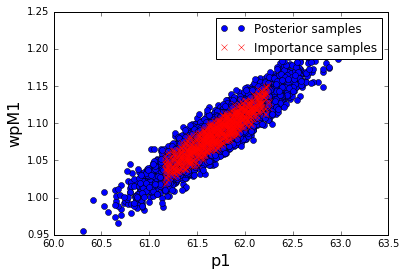

In [20]:
print("Possible parameters to plot:", param_IS_keys)

a, b = param_IS_keys[0], param_IS_keys[-1]

plt.plot(postSamp_pKhkl[a], postSamp_pKhkl[b], 'o', color='blue')
plt.plot(importSamp_dict[a], importSamp_dict[b], 'x', color='red')
plt.legend(["Posterior samples","Importance samples"])
plt.xlabel(a, fontsize=16)
plt.ylabel(b, fontsize=16)
plt.legend()

### <center> 3.3. Evaluate importance samples at $p(\vec{d}|\vec{\theta})p(\vec{\theta})$. </center>

After transforming back into pKewM space...

In [21]:
importSamp_pKhkl_dict = compute.pKhkl_to_pKewM(importSamp_dict, param_keys, nPlanets)
importSamp_pKewM = np.transpose([ vals for key, vals in importSamp_pKhkl_dict.items() ])

...we feed our importance samples into $\tt{lnpost}$, defined above when doing the $\tt{emcee}$ runs. Here we go!

In [22]:
f = FloatProgress(min=0, max=nImportSamps)
display(f)

logPosteriors = np.array([ np.nan for i in range(nImportSamps) ])
for i in range(nImportSamps): 
    logPosteriors[i] = lnpost(importSamp_pKewM[i], obs)
    f.value = i
    
print("Done evaluating lnpost")

Done evaluating lnpost


Now to sum over $p(\vec{\theta_i})p(\vec{d}|\vec{\theta_i})/g(\vec{\theta_i})$ then divide by the number of importance samples. These numbers are probably ridiculously small, so we'll operate on $\log[p(\vec{\theta_i})p(\vec{d}|\vec{\theta_i})]$ and $\log[g(\vec{\theta_i})]$

In [23]:
logSum = -(9.**99.)

for i in range(nImportSamps):    
    diff = logPosteriors[i] - loggs[i]
    logSum = np.logaddexp(logSum, diff)
    
    if i%100==1:
        print("logAvg estimate after", i, "samples:", logSum - np.log(i))

logAvg = logSum - np.log(nImportSamps)
print(logAvg)

logAvg estimate after 1 samples: -98.1925644879
logAvg estimate after 101 samples: -98.8405411955
logAvg estimate after 201 samples: -98.8450762549
logAvg estimate after 301 samples: -98.8487637497
logAvg estimate after 401 samples: -98.8489639966
logAvg estimate after 501 samples: -98.849162407
logAvg estimate after 601 samples: -98.8503374426
logAvg estimate after 701 samples: -98.8505849584
logAvg estimate after 801 samples: -98.8494660263
logAvg estimate after 901 samples: -98.8488435355
-98.8503299742


And finally, we'll supplement the information lost from when we drew from a truncated normal. Here, we compute the fraction of MCMC samples that fell within our hypercube $\tt{f_{MCMC}}$.

In [24]:
f_MCMC = 0.

postSamp_wo_keys = []
for key in postSamp_pKhkl:
    postSamp_wo_keys.append(postSamp_pKhkl[key])
    
postSamp_wo_keys = np.transpose(np.array(postSamp_wo_keys))
diff = postSamp_wo_keys-mediansG

for j in range(nPostSamples):

    z = np.linalg.solve(choleskyDecomp, diff[j])

    if all([abs(k)<=scale for k in z]):
        f_MCMC += 1.
    else:
        f_MCMC += 0.
        
f_MCMC = f_MCMC/nPostSamples
logFML = logAvg - np.log(f_MCMC)
print("f_MCMC:", f_MCMC)
print("logFML:", logFML)

f_MCMC: 0.4846
logFML: -98.1258985036


We've now computed the fully marginalized likelihood for the one-planet model!

---
<a id='section3.4'></a>
### <center> 3.4. The real deal: computing Bayes factor for one- and two-planet models. </center>
Let's gather all these functions together into a new module called $\tt{FML.py}$. Now we have a general algorithm to compute Bayes factors for a given input model.

In [25]:
import FML

In [26]:
FML_1pl = FML.computeFML(samples_1pl, obs=obs, nPlanets=1, nImportSamps=10000, scale=1.5)

Drawing importance samples...
Done drawing importance samples!

Evaluating lnpost at importance samples...
Done evaluating lnpost!

FML computed!
Done!


In [27]:
FML_2pl = FML.computeFML(samples_2pl, obs=obs, nPlanets=2, nImportSamps=10000, scale=1.5)

Drawing importance samples...
Done drawing importance samples!

Evaluating lnpost at importance samples...
Done evaluating lnpost!

FML computed!
Done!


The ratio of the FMLs (or difference of log[FML]s) gives a Bayes factor (log[Bayes factor]). We can compare our results to other model comparison choices such as the Bayesian or Akaike Information Criterion (BIC and AIC respectively).

In [28]:
def AIC(MLE, obs):
    return 2. * len(MLE) - 2*lnlike(MLE, obs)

def BIC(MLE, obs):
    return np.log(len(obs.rv)) * len(MLE) - 2*lnlike(MLE, obs)


BIC_1pl, BIC_2pl = BIC(MLE_1pl, obs), BIC(MLE_2pl, obs)
AIC_1pl, AIC_2pl = AIC(MLE_1pl, obs), AIC(MLE_2pl, obs)

print("log Bayes Factor :", FML_2pl.logFML - FML_1pl.logFML)
print("delta BIC        :", BIC_1pl - BIC_2pl)
print("delta AIC        :", AIC_1pl - AIC_2pl)

log Bayes Factor : 8.86305916074
delta BIC        : 22.7830183113
delta AIC        : 32.3431333384
